In [1]:
import numpy as np
from scipy import sparse
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import random
import gudhi

In [2]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular, square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded = bool
        #                                     band_length = gonna connect this many closest neigbors (skipping the 
        #                                                   adjacent nodes from both sides because they are already 
        #                                                   connected) from both sides to every node
        #                                     
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.N
        ### attribute -- geometric_network.M
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        ### attribute -- geometric_network.text 
        
        ### function -- geometric_network.display(n_size, labels = Bool): take a sneakpeak on the networkx object
        ### function -- geometric_network.add_noise_to_geometric(noise_type, d2): add two types of noise
        #                                   either 'ER_like' or 'k_regular' of degree d2
        ### function -- geometric_network.run_excitation(Trials, p, T, seed, threshold): run 
        #                                   the excitation according to these parameters
        
        ### function -- geometric_network.spy_first_activation(first_activation_times): visualize the first
        #                                   activation, input of the functin is the 2nd output of run_excitation
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        elif network_type == 'ring_lattice':# TODO: banding for every node
            self.graph = nx.cycle_graph(size)
            theta = (2*np.pi)/size
            self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
            self.M = len(self.graph.edges())
            self.N = len(self.graph.nodes())
            self.text = 'Ring Lattice'
            if kwargs['banded']:
                if kwargs['band_length'] >= int(self.N/2)-1: 
                    raise ValueError('Band length cannot exceed the half of the size of the network')
                if kwargs['band_length'] <2: 
                    raise ValueError('Band length should be a positive integer greater 1 since the closest neighbors are already connected')
                for u in range(self.N):
                    for i in range(2,kwargs['band_length']+1):
                        # ranges from 2 to k+2 to avoid the closest node and start
                        ## banding from the second closest node
                        if u + i >= self.N: v = u + i - self.N
                        else: v = u + i
                        self.graph.add_edge(u, v)
                        if u - i < 0: v = self.N + u - i
                        else: v = u - i
                        self.graph.add_edge(u, v)
                self.text = self.text + ' w/ bandlength %d'%kwargs['band_length']
            else:self.text = self.text + ' w/ bandlength 0'
                        
        else: raise ValueError('network type can be a lattice or a ring')
            
        self.A = nx.adjacency_matrix(self.graph)
        ## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph, 
                            pos = self.pos, 
                            node_size = n_size, 
                            with_labels = labels, 
                            font_weight = 'bold'))
        
        except: return(nx.draw(self.graph, with_labels = labels, font_weight = 'bold'))
        
    def add_noise_to_geometric(self, noise_type, d2):
        
        # this function adds nongeometric edges to the network that are long range. Depending on the 'noise_type'
        # the way we add these long range edges differ. If noise_type = ER_like, then there will be d2 many
        # non geometric edges ON AVARAGE for every node. When the noise_type = k_regular, every node will 
        # have exactly d2 many long range edges
        
        
        if noise_type == 'ER_like':   
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
                
            edges_built = 0
            
            while edges_built <= M/2:
                
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A.toarray()[nodes_to_connect[0]][nodes_to_connect[1]] == 1 or self.A.toarray()[nodes_to_connect[1]][nodes_to_connect[0]] == 1: # no existing loops
                    edges_built = edges_built
                else: 
                    self.graph.add_edge(nodes_to_connect[0],nodes_to_connect[1])
                    edges_built = edges_built + 1
            self.text = self.text + ' & ER-like noise w/ degree %d'%d2

                    
        elif noise_type == 'k_regular':
            
            self.text = self.text + ' & k-regular noise w/ degree %d'%d2
            
            M = int(self.N * d2)
        
            if M%2 == 1: raise ValueError('Try providing an even non-geometric degree')
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                #build stubs
                stubs = np.zeros(M)
                for i in range(self.N):
                    index = (i*d2) + np.arange(d2)
                    stubs[index[0]:index[-1]+1] = (i) * np.ones(d2)
                    
                #build undirected link list
                link_list = np.zeros((int(M/2),2))
                for m in range(int(M/2)):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        
                        node_A = int(stubs[rand[0]])
                        node_B = int(stubs[rand[1]])
                                                
                        if node_A == node_B: flag_1 = True
                        
                        for n in range(m):
                            if link_list[n,0] == node_A and link_list[n,1] == node_B:
                                flag_1 = True
                            if link_list[n,0] == node_B and link_list[n,1] == node_A:
                                flag_1 = True
                            if self.A.toarray()[node_A][node_B] == 1 or self.A.toarray()[node_B][node_A] == 1:
                                flag_1 = True
                                
                        count = count +1
                        
                        if count > M: flag_2 = True ; break
                            
                    #make link       
                    link_list[m,0] = node_A
                    link_list[m,1] = node_B
                    
                    #remove stubs from list
                    stubs = np.delete(stubs,[rand[0],rand[1]])
            
            #build network
            for m in range(int(M/2)):
                self.graph.add_edge(link_list[m,0],link_list[m,1])
            
        else: raise InputError('Noise type can only be ER_like or k_regular')
        
        self.A = nx.adjacency_matrix(self.graph)
        
    def excitation(self, T, C, seed, threshold, refractory = False, ax = None, spy = False):
        
                            ### THE CORE FUNCTION OF THE NEURONAL CONTAGION MODEL###
        
        # In this model, a neuron fires if the ratio of it's excited neighbors to the total number of neighbors
        # is greater than the threshold. Let's call the difference between this ratio and the threshold = F 
        # so that if F is positive, neuron is going to fire and it doesn't fire when it's negative. We add some 
        # stocasticity to the model by defining the sigmoid function so that the probability that the 
        # neuron is going to fire is not a step function, but a sigmoid function.
        
        ################################################################################################
        
        #### Inputs : 
        ##           T: Number of time steps contagions is going to be iterated
        
        ##           C: A positive constant for the sigmoid function, if C is too large(>100), 
        #               jump from 0 to 1 is gonna be too quick i.e. model is going to be deterministic
        
        ##          seed: node id to start the contagion, in the first time step, we infect 
        #                 the neighbors of the seed with probablity 1 then enter the while loop below
        
        ##          threshold: threshold to compare for a neuron's neighbor input
        
        ##          refractory: if TRUE, sets the refractory period of 1 time step i.e. neuron cannot fire for 
        #                      1 time step right after it fires. if FALSE, neuron stays active once its activated.
        
        ##          ax, spy: if spy is TRUE, there have to be an axis provided to plot the contagion spread.
        
        #### Outputs : 
        ##          activation_times: An array of n x 1 keeping track of the first time step the corresponding 
        #                             node gets activated.
        
        ##          size_of_contagion: An array of (T+1) x 1 keeping track of the number of active nodes at a
        #                              given time(at t = 0, all neighbors of the seed is active)
        
        #################################################################################################
        
        n = self.N
        x_1 = sparse.lil_matrix(((n,T+1)), dtype = bool)
        activation_times = np.ones(n, dtype = int)*T
        
        excited_nodes = self.A[seed].nonzero()[1]
        
        deg = len(excited_nodes)
        
        size_of_contagion = np.zeros(T+1)
        
        vals = [True] * deg
        
        t = 0
        
        for i in range(deg): 
            x_1[excited_nodes[i],t] = vals[i]
            
        all_nodes = set([k for k in range(n)])
        size_of_contagion[t] = len(excited_nodes)
        
        while t<T and len(excited_nodes)>0 and np.any(activation_times==T):
            x_old = x_1.toarray()[:,t]
            excited_nodes = np.nonzero(x_old)[0]         
            activation_times[excited_nodes] = np.minimum(activation_times[excited_nodes], 
                                                         np.array([t]*len(excited_nodes)))
            activation_times = activation_times.astype(np.int32)
            t+=1
            for j in list(all_nodes-set(excited_nodes)): 
                ids = np.nonzero(self.A[j])[1]
                F = np.sum(x_old[ids])/len(ids) - threshold 
                Z = 1/(1+np.exp(-C*F)) 
                rand = random.uniform(0,1)
                x_1[j,t] = bool(rand<Z) 
                
            if not refractory: x_1[x_old,t] = True 
            
            size_of_contagion[t] = np.sum(x_1[:,t])
      
        if spy: ax.imshow(x_1.todense())
        return(activation_times, size_of_contagion)
    
    
    def run_excitation(self, Trials, T, C, seed, threshold, refractory, ax = None):
        
        n = self.N
        
        first_excitation_times = np.zeros((n,Trials))
        size_of_contagion = np.zeros((T+1,Trials))
        
        if ax is not None: 
            for i in range(Trials):
    
                first_exct, contagion_size = self.excitation(T = T, 
                                                             C = C, 
                                                             seed = seed, 
                                                             threshold = threshold, 
                                                             refractory = refractory,
                                                             ax = ax[i], 
                                                             spy = True)
                first_excitation_times[:,i] = first_exct
                size_of_contagion[:,i] = contagion_size
                ax[i].set_title('Trial %d for %s'%(i+1, self.text), fontsize = 25)
                ax[i].set_xlabel('Time', fontsize = 35)
                ax[i].set_ylabel('Node ID',fontsize = 35)
                ax[i].set_xticks([5*t for t in range(int(T/5)+1)])
                ax[i].set_yticks([10*t for t in range(int(n/10))])
                ax[i].tick_params('both', which = 'major', labelsize = 15)
            plt.tight_layout()
            
        else:
            for i in range(Trials):
    
                first_exct, contagion_size = self.excitation(T = T, 
                                                             C = C, 
                                                             seed = seed, 
                                                             threshold = threshold, 
                                                             refractory = refractory)
                first_excitation_times[:,i] = first_exct
                size_of_contagion[:,i] = contagion_size
            
        return(first_excitation_times, size_of_contagion)
    

    def spy_first_activation(self, first_activation_times):
        
        fig,ax = plt.subplots(1,1,figsize = (10,8))
        
        pos = ax.imshow(first_activation_times, 
                        interpolation = 'nearest', 
                        aspect = 'auto', 
                        cmap = 'viridis', 
                        extent = [0.5,Trials+0.5,0,n])
        ax.set_title('First Activation Times for %s'%self.text, fontsize = 20)
        ax.set_xlabel('Trials', fontsize = 15)
        ax.set_ylabel('Node ID', fontsize = 15)
        ax.set_xticks([i for i in range(1,Trials+1)])
        
        fig.colorbar(pos, ax = ax)
        
    def average_over_trials(self, matrix): ##matrix to take the average over trials
        ## matrix have to be k x T where T is the number of trials
        return(np.mean(matrix, axis = 1))
    
    def make_distance_matrix(self, T, C, threshold, Trials, refractory, spy_distance = False):
        n = self.N
        D = np.zeros((n,n))
        Q = np.zeros((n,T+1))
        
        for i in range(n):
            fat, qs = self.run_excitation(Trials, T, C, i, threshold, refractory)
            D[i], Q[i] = self.average_over_trials(fat), self.average_over_trials(qs)
        
        if spy_distance: 
            fig,ax = plt.subplots(1,1, figsize = (15*int(n/20),10*int(n/20)))
            pos = ax.imshow(D, 
                            origin = 'lower', 
                            interpolation = 'nearest', 
                            aspect = 'auto', 
                            cmap = 'viridis', 
                            extent = [-0.5,n-0.5,-0.5,n-0.5])
            ax.set_title('Distance Matrix for %s'%self.text, fontsize = 20)
            ax.set_ylabel('Excitation starting from node i', fontsize = 15)
            ax.set_xlabel('First time node j gets activated', fontsize = 15)
            ax.set_xticks([i*5 for i in range(int(n/5))])
            ax.set_yticks([i*5 for i in range(int(n/5))])

            fig.colorbar(pos, ax = ax)
        return(D,Q)
    
    def compute_persistence(self, distances, spy = False):    
        rips_complex = gudhi.RipsComplex(distance_matrix = distances/np.max(distances), max_edge_length = 1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
        diag = simplex_tree.persistence(min_persistence = 0.0)
        if spy: 
            gudhi.plot_persistence_diagram(diag)
        return(diag)
    
    def one_d_Delta(self, persistence):
        oned_holes = [(0,0)]
        for i in range(len(persistence)):
            if persistence[i][0] == 1:
                oned_holes.append(persistence[i][1])
        oned_holes = np.array(oned_holes)
        persistence_life_times = oned_holes[:,1]-oned_holes[:,0]
        Delta_min = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[-2]
        Delta_max = np.sort(persistence_life_times)[-1]-np.sort(persistence_life_times)[1]
        Delta_avg = np.mean(persistence_life_times[1:])
        return(Delta_min, Delta_max, Delta_avg)

In [3]:
def display_comm_sizes(Q, labels):
    fig,ax = plt.subplots(1,1, figsize =(20,10))
    for i in range(len(Q)):
        Q_mean = np.mean(Q[i], axis = 0)
        ax.plot(Q_mean[:int(np.max(np.nonzero(Q)[2])+1)], 
                label = '%s'%labels[i], marker = 'v')
        
        X = np.linspace(0,int(np.max(np.nonzero(Q)[2])),int(np.max(np.nonzero(Q)[2])+1))
        ax.fill_between(X, 
                        np.max(Q[i], axis = 0)[:int(np.max(np.nonzero(Q)[2])+1)], 
                        np.min(Q[i], axis = 0)[:int(np.max(np.nonzero(Q)[2])+1)], 
                        alpha = 0.2)
    ax.set_title('Size of the Active Nodes', fontsize = 25)
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Number of Nodes', fontsize = 20)
    ax.legend(fontsize = 'x-large')

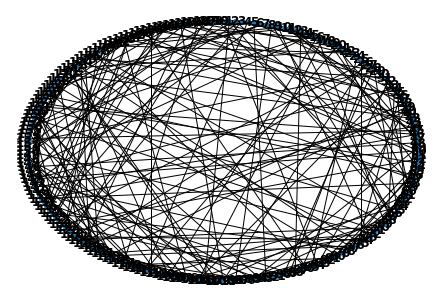

In [35]:
n = 200
d2 = 2
ring_latt_k_regular =  geometric_network('ring_lattice', size = n, banded = True, band_length = 3)
ring_latt_k_regular.add_noise_to_geometric('k_regular', d2)
ring_latt_k_regular.display()
#plt.savefig('/Users/bengieru/Dane/docs/source/networkx.png')

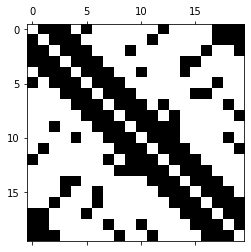

In [5]:
plt.spy(ring_latt_k_regular.A.todense())

# 2) Sample Excitation Simulation
   ### Use .run_exciation() method for the desired network. Output is the first activation times

In [22]:
T = 500 # number of iterations
seed = int(n/2) # node that the spread starts
C = 1000
threshold = np.linspace(0.1,0.6,6) # resistence of the node to it's neighbors' excitation level
Trials = 2 # number of trials
refractory_period = False

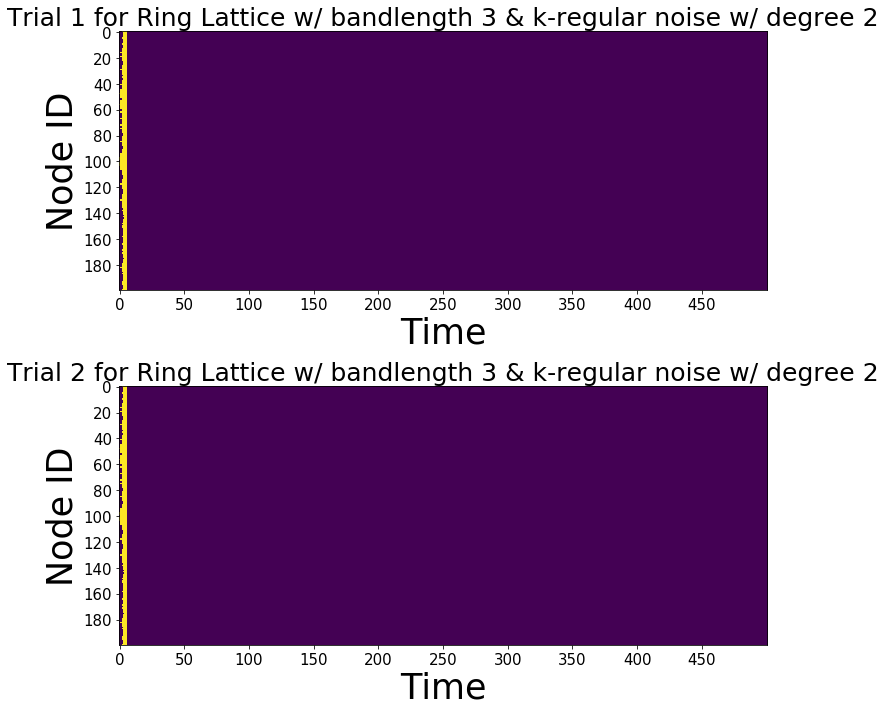

In [25]:
fig, ax = plt.subplots(Trials,1, figsize = (50,10))
first_excitation_times1, contagion_size1 = ring_latt_k_regular.run_excitation(Trials, 
                                                                              T, 
                                                                              C, 
                                                                              seed, 
                                                                              threshold[0], 
                                                                              refractory_period, 
                                                                              ax = ax)
ax[0].set_xticks([i*50 for i in range(int(T/50))])
ax[0].set_yticks([i*20 for i in range(int(n/20))])
ax[1].set_xticks([i*50 for i in range(int(T/50))])
ax[1].set_yticks([i*20 for i in range(int(n/20))])
#plt.savefig('/Users/bengieru/Dane/docs/source/networkx.png')

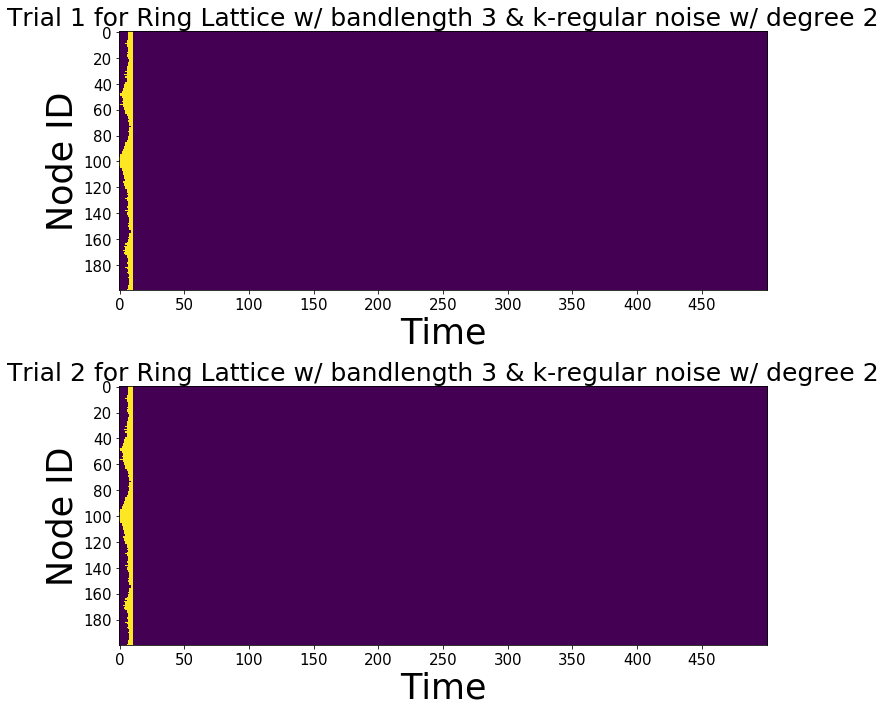

In [26]:
fig, ax = plt.subplots(Trials,1, figsize = (50,10))
first_excitation_times2, contagion_size2 = ring_latt_k_regular.run_excitation(Trials, 
                                                                              T, 
                                                                              C, 
                                                                              seed, 
                                                                              threshold[1], 
                                                                              refractory_period, 
                                                                              ax = ax)
ax[0].set_xticks([i*50 for i in range(int(T/50))])
ax[0].set_yticks([i*20 for i in range(int(n/20))])
ax[1].set_xticks([i*50 for i in range(int(T/50))])
ax[1].set_yticks([i*20 for i in range(int(n/20))])

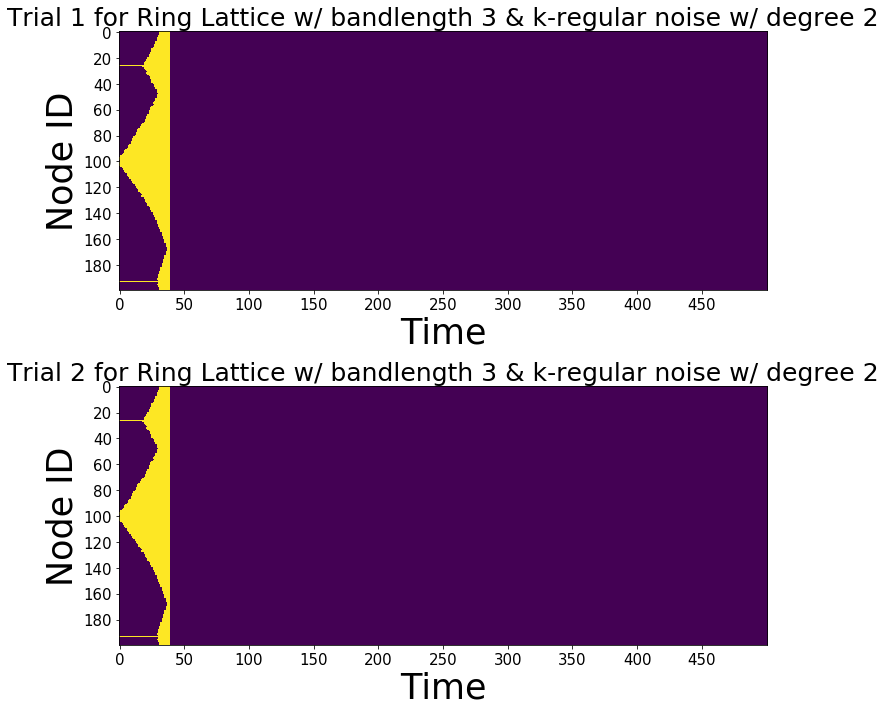

In [37]:
fig, ax = plt.subplots(Trials,1, figsize = (50,10))
first_excitation_times3, contagion_size3 = ring_latt_k_regular.run_excitation(Trials, 
                                                                              T, 
                                                                              C, 
                                                                              seed, 
                                                                              threshold[2], 
                                                                              refractory_period, 
                                                                              ax = ax)
ax[0].set_xticks([i*50 for i in range(int(T/50))])
ax[0].set_yticks([i*20 for i in range(int(n/20))])
ax[1].set_xticks([i*50 for i in range(int(T/50))])
ax[1].set_yticks([i*20 for i in range(int(n/20))])
plt.savefig('/Users/bengieru/Dane/docs/source/contagion.png')

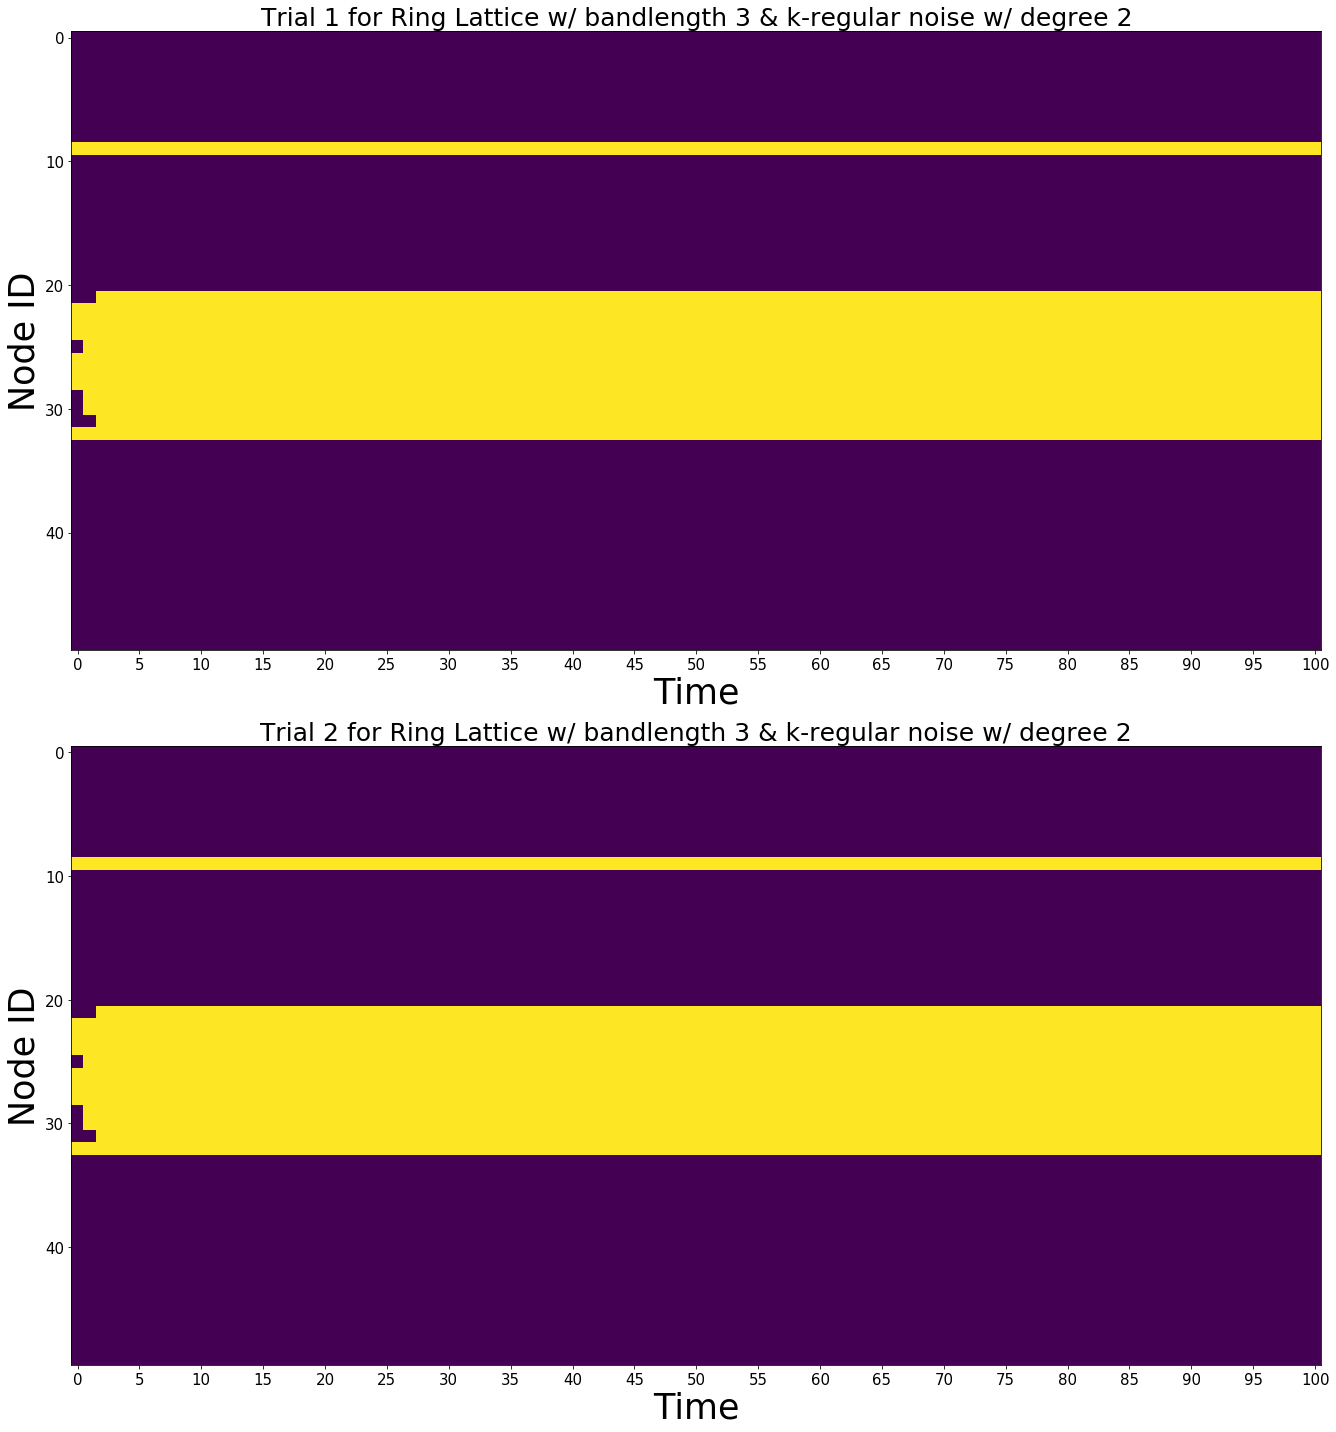

In [10]:
fig,ax = plt.subplots(Trials,1, figsize = (50,20))
first_excitation_times4,contagion_size4 = ring_latt_k_regular.run_excitation(Trials, 
                                                                             T, 
                                                                             C, 
                                                                             seed, 
                                                                             threshold[3], 
                                                                             refractory_period, 
                                                                             ax = ax)

# 3) Observing the first activation times
### input the output of the run_excitation to the .spy_first_activation() method

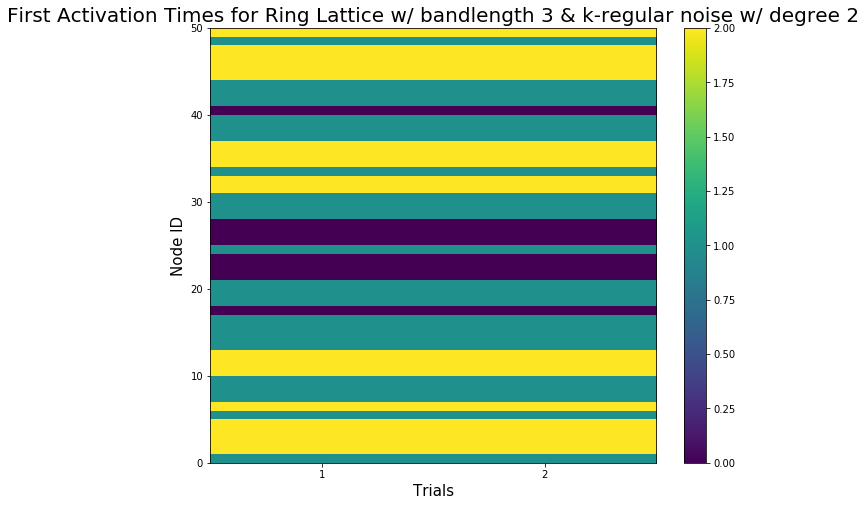

In [11]:
ring_latt_k_regular.spy_first_activation(first_excitation_times1)

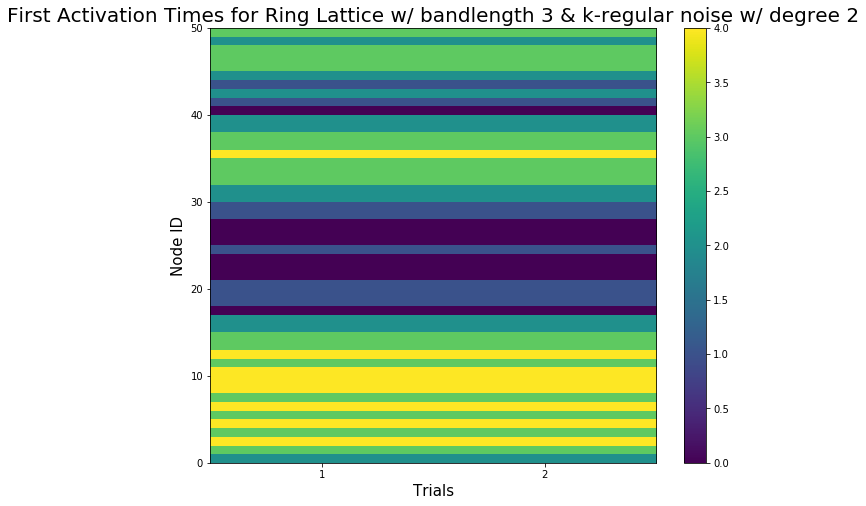

In [12]:
ring_latt_k_regular.spy_first_activation(first_excitation_times2)

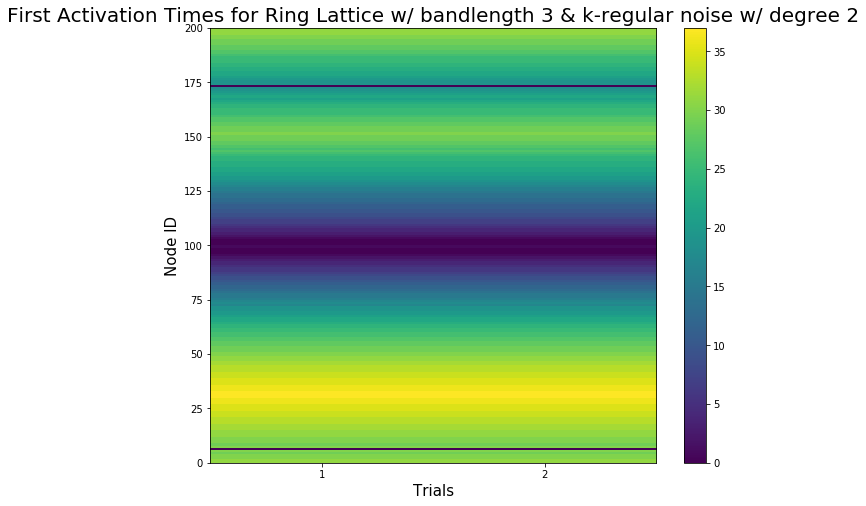

In [38]:
ring_latt_k_regular.spy_first_activation(first_excitation_times3)
plt.savefig('/Users/bengieru/Dane/docs/source/first_activation.png')

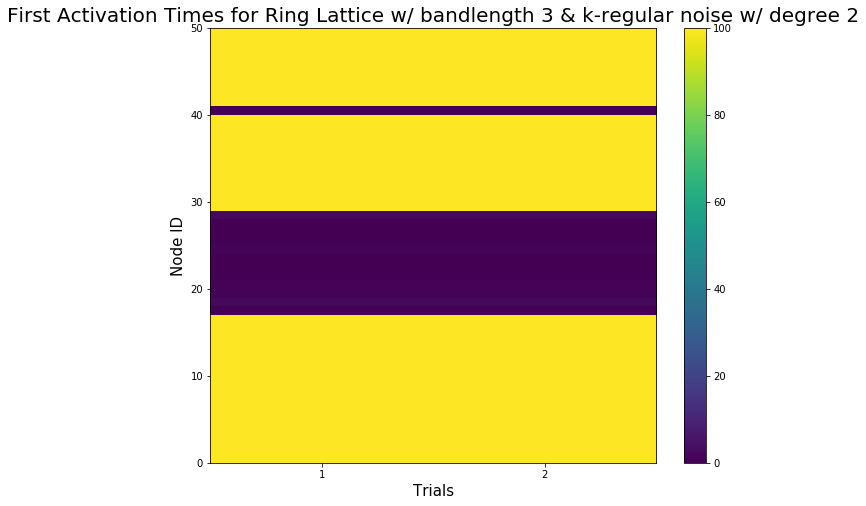

In [14]:
ring_latt_k_regular.spy_first_activation(first_excitation_times4)

# 4) You can run everything so far with make_distance_matrix
### it's gonna run the simulation starting from node i and finding first activation of node j, taking averages over the number of trials and put everything into a distance matrix

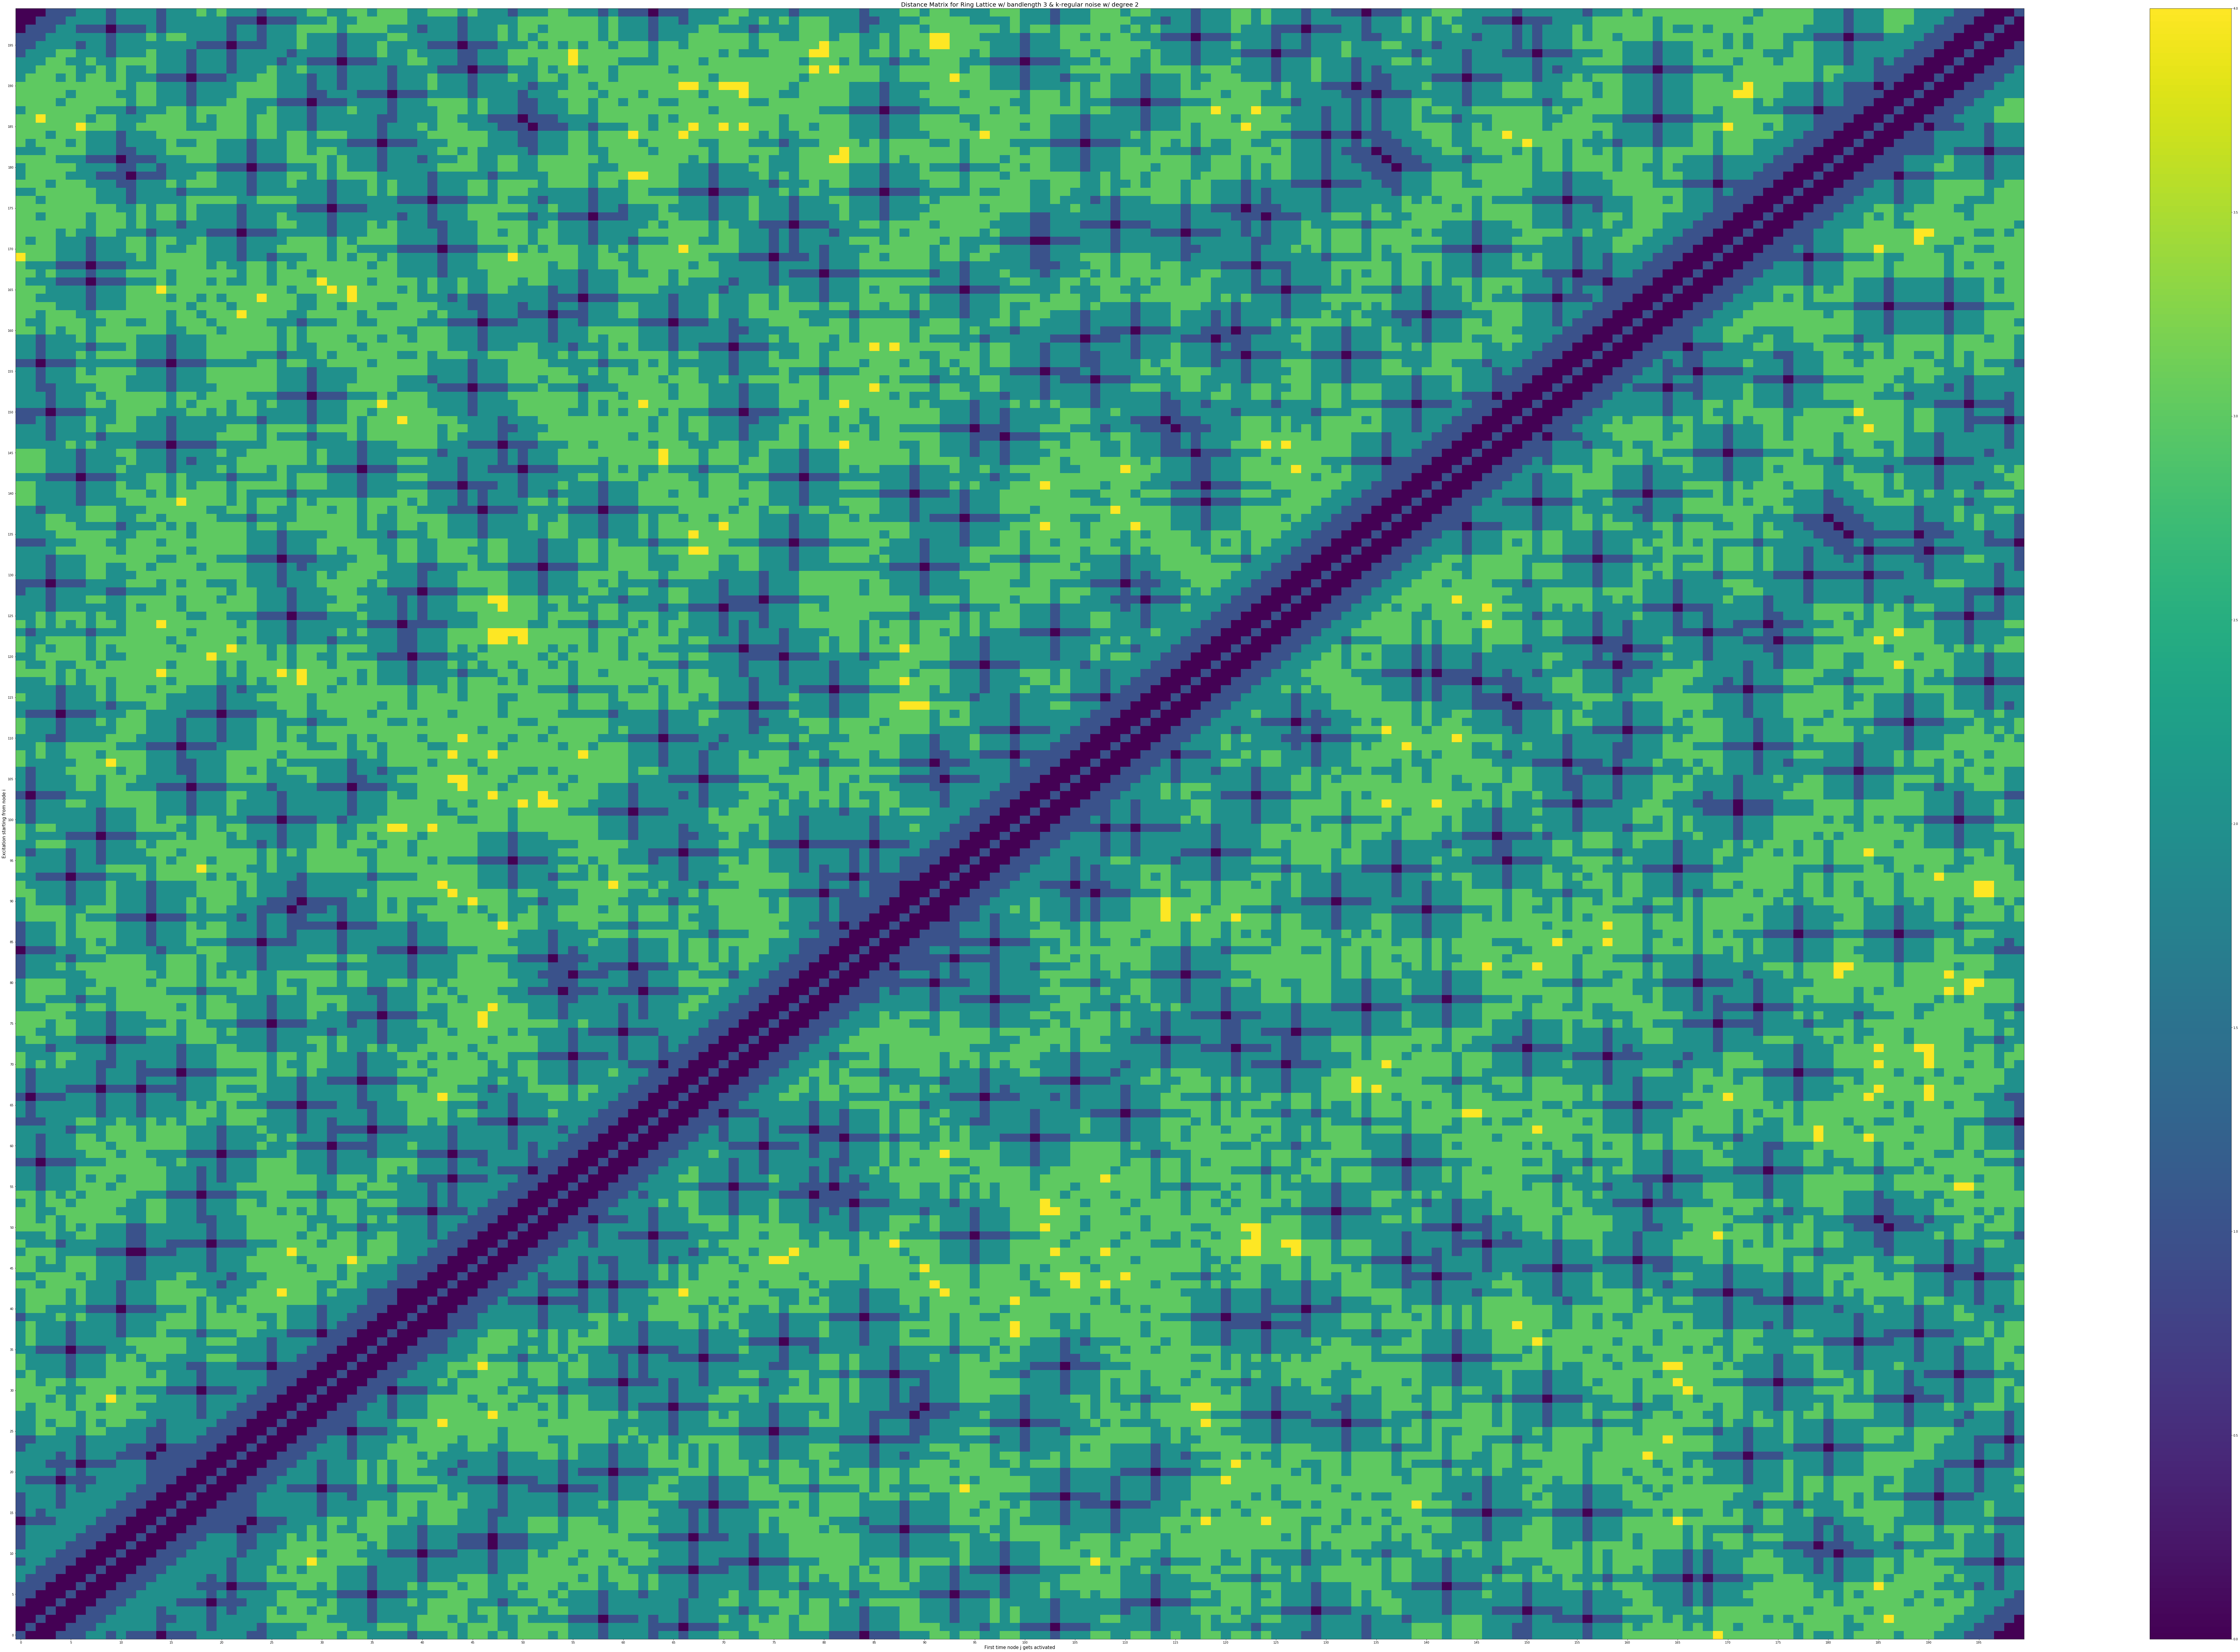

In [42]:
D1,Q1 = ring_latt_k_regular.make_distance_matrix(T, 
                                                 C, 
                                                 threshold[0], 
                                                 Trials, 
                                                 refractory_period, 
                                                 spy_distance = True)

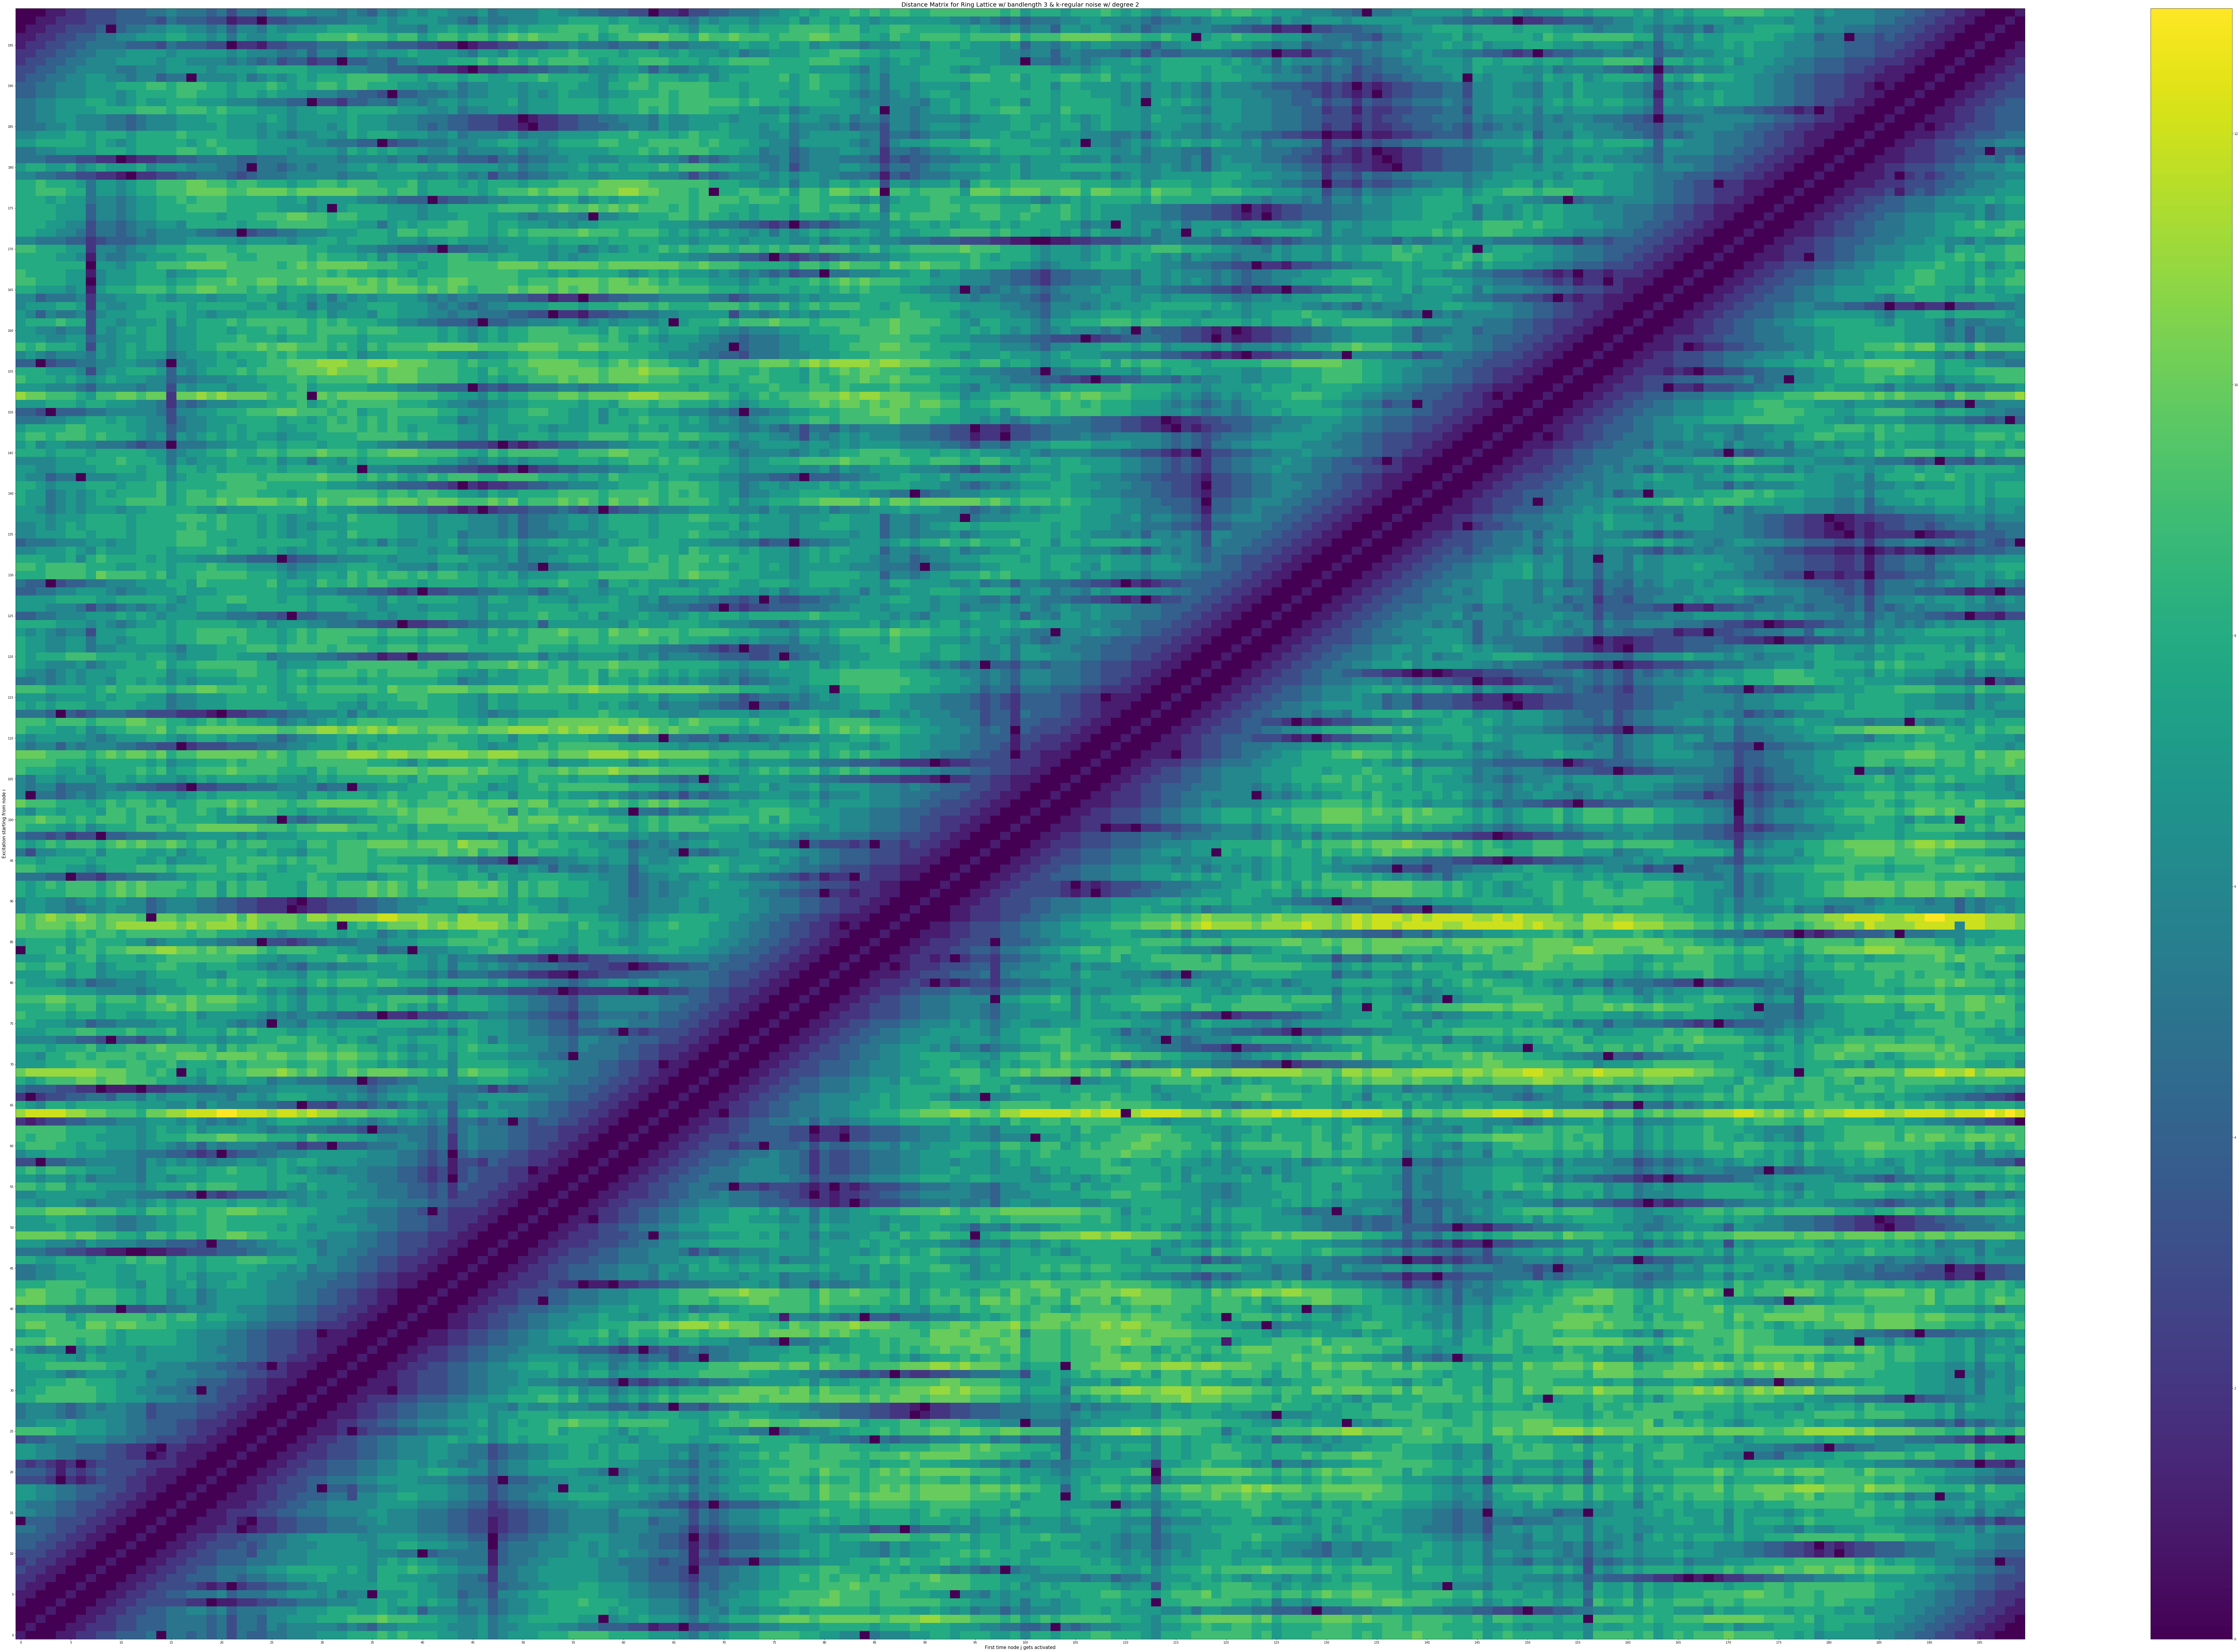

In [43]:
D2,Q2 = ring_latt_k_regular.make_distance_matrix(T, 
                                                 C, 
                                                 threshold[1], 
                                                 Trials, 
                                                 refractory_period, 
                                                 spy_distance = True)

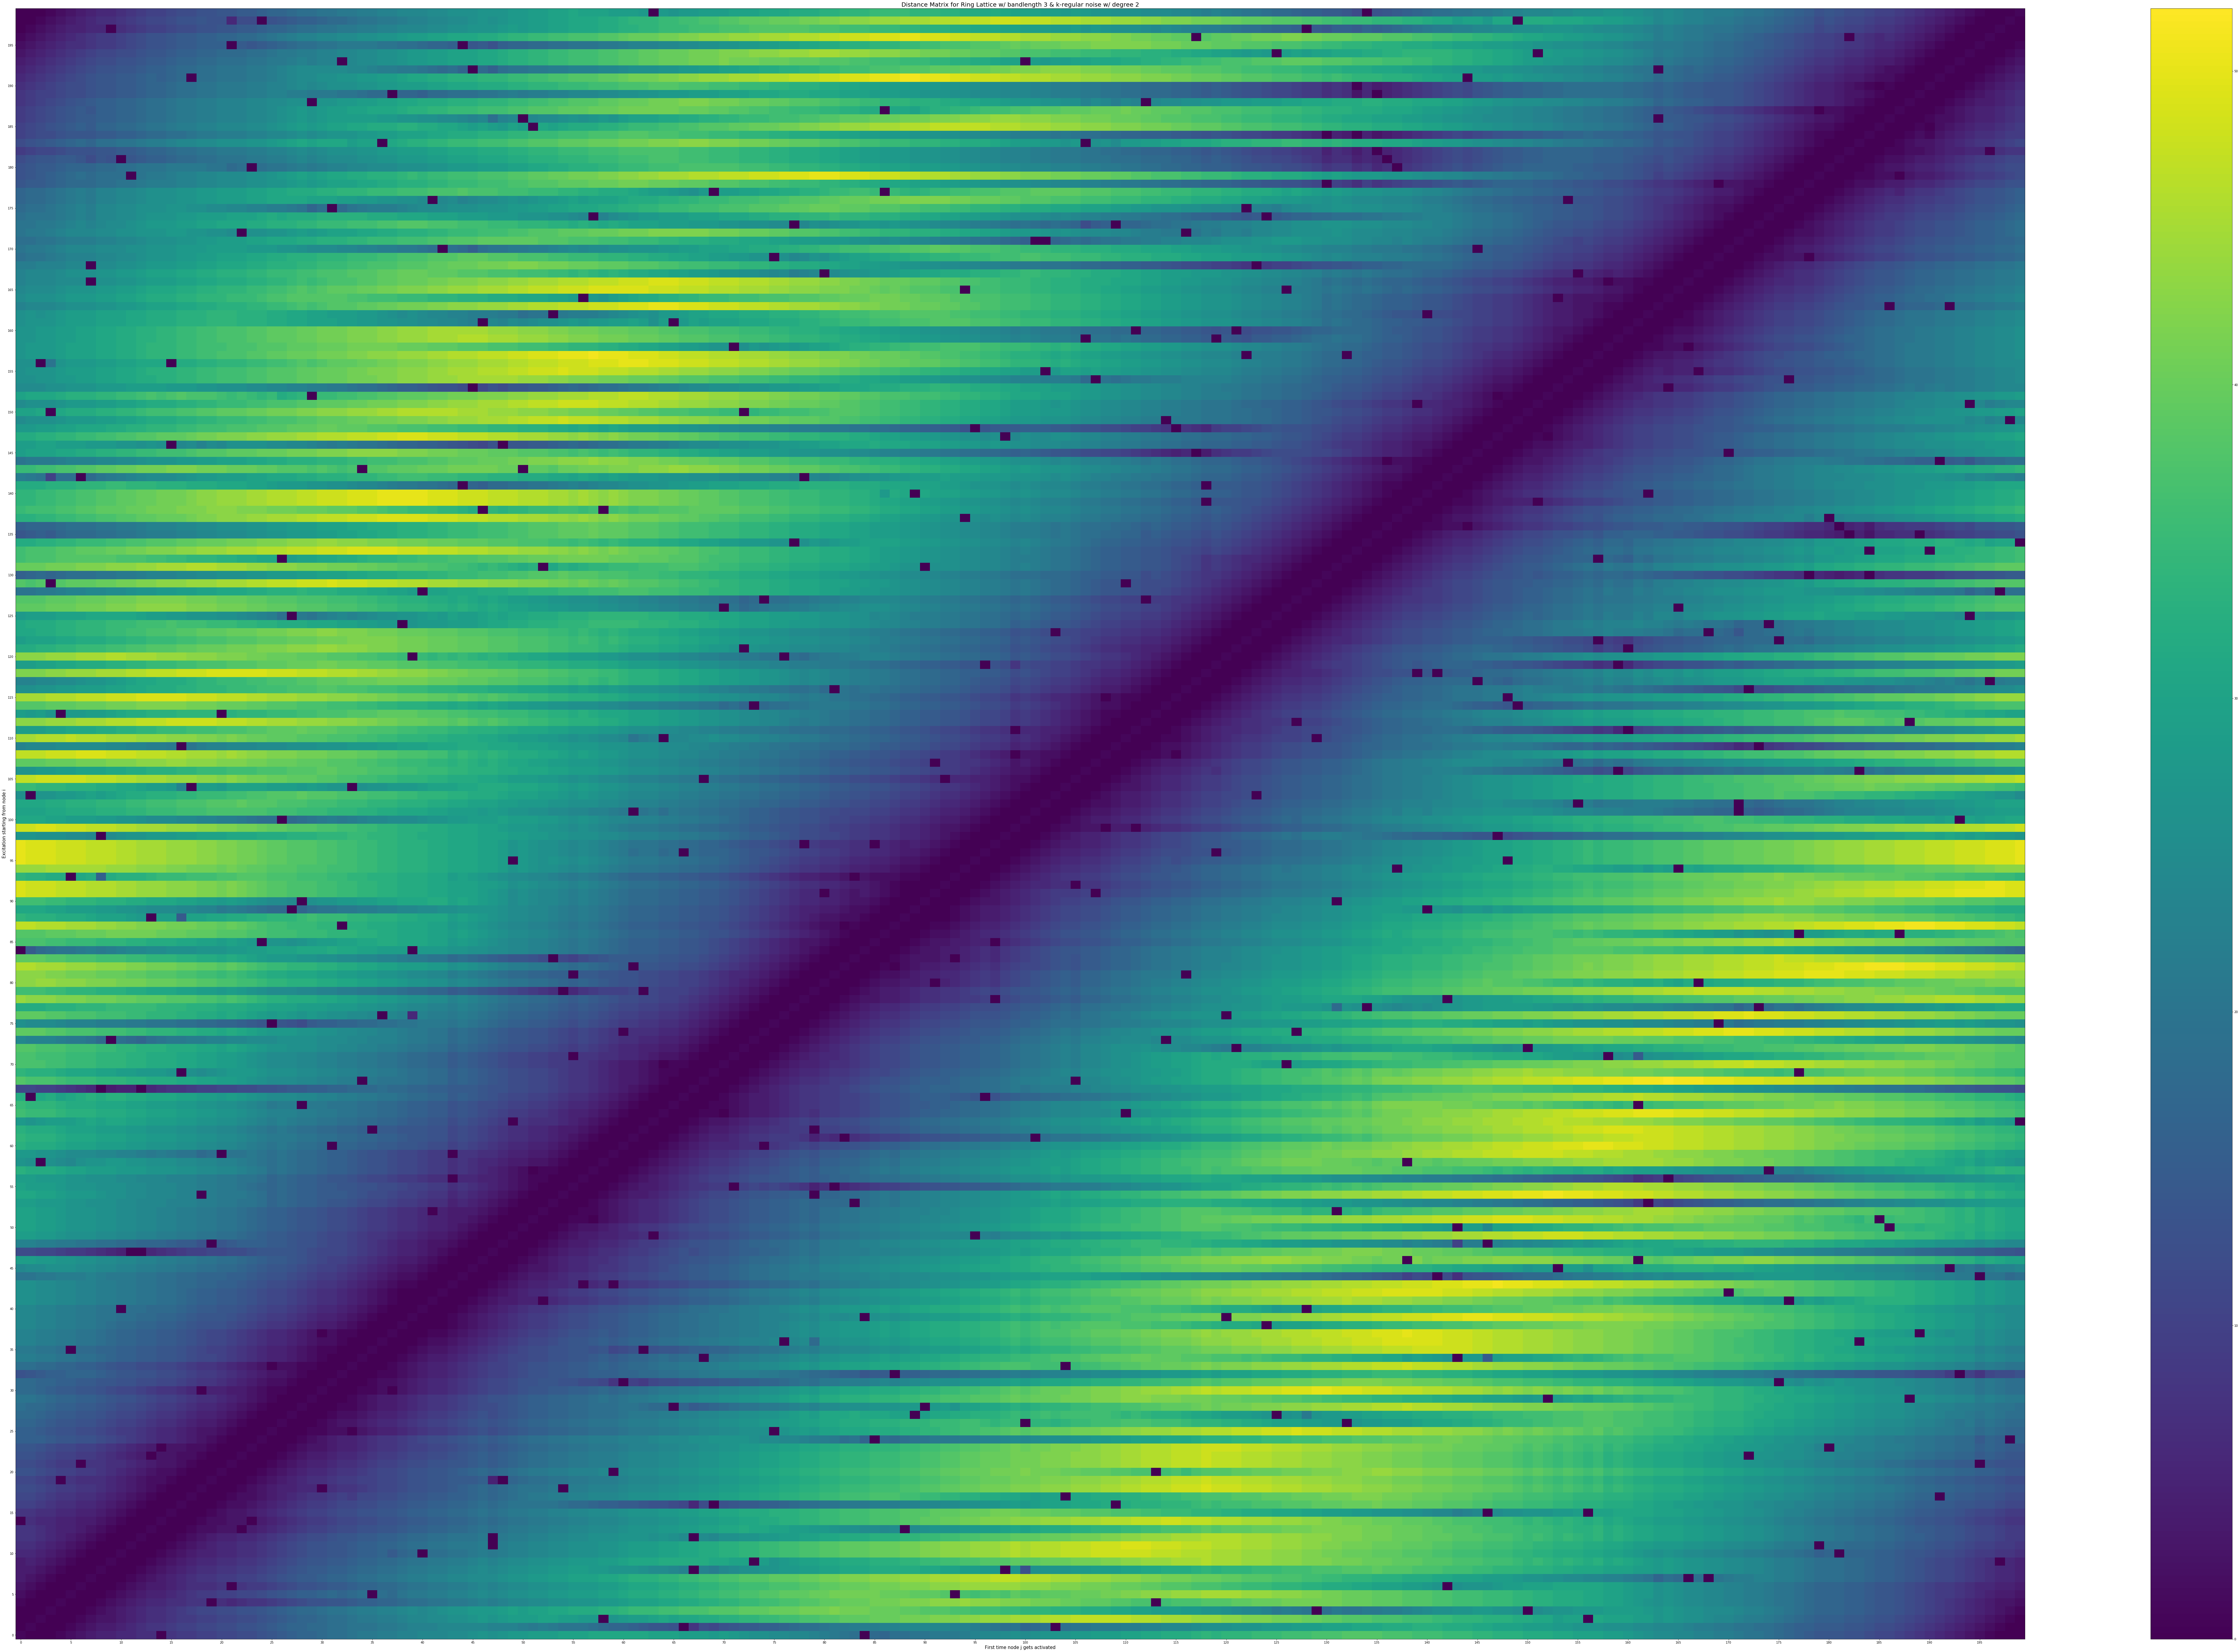

In [40]:
D3,Q3 = ring_latt_k_regular.make_distance_matrix(T, 
                                                 C, 
                                                 threshold[2], 
                                                 Trials, 
                                                 refractory_period, 
                                                 spy_distance = True)
plt.savefig('/Users/bengieru/Dane/docs/source/distance_matrix.png')

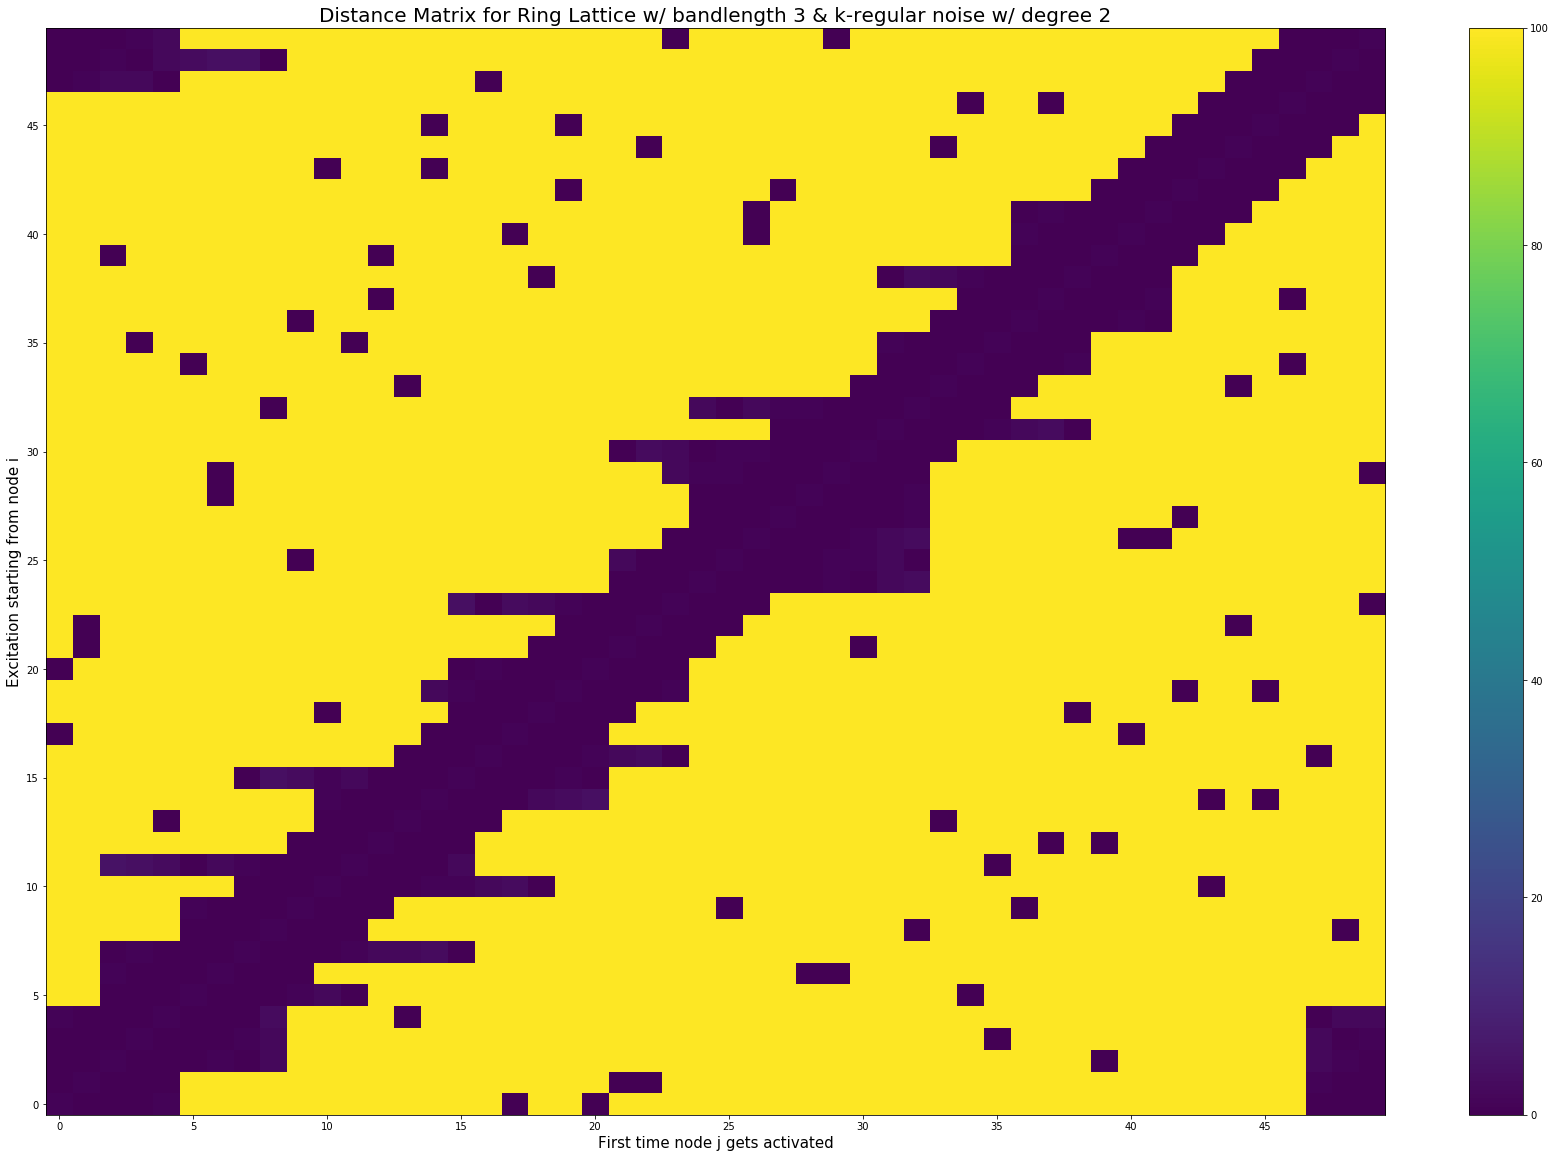

In [18]:
D4,Q4 = ring_latt_k_regular.make_distance_matrix(T, 
                                                 C, 
                                                 threshold[3], 
                                                 Trials, 
                                                 refractory_period, 
                                                 spy_distance = True)

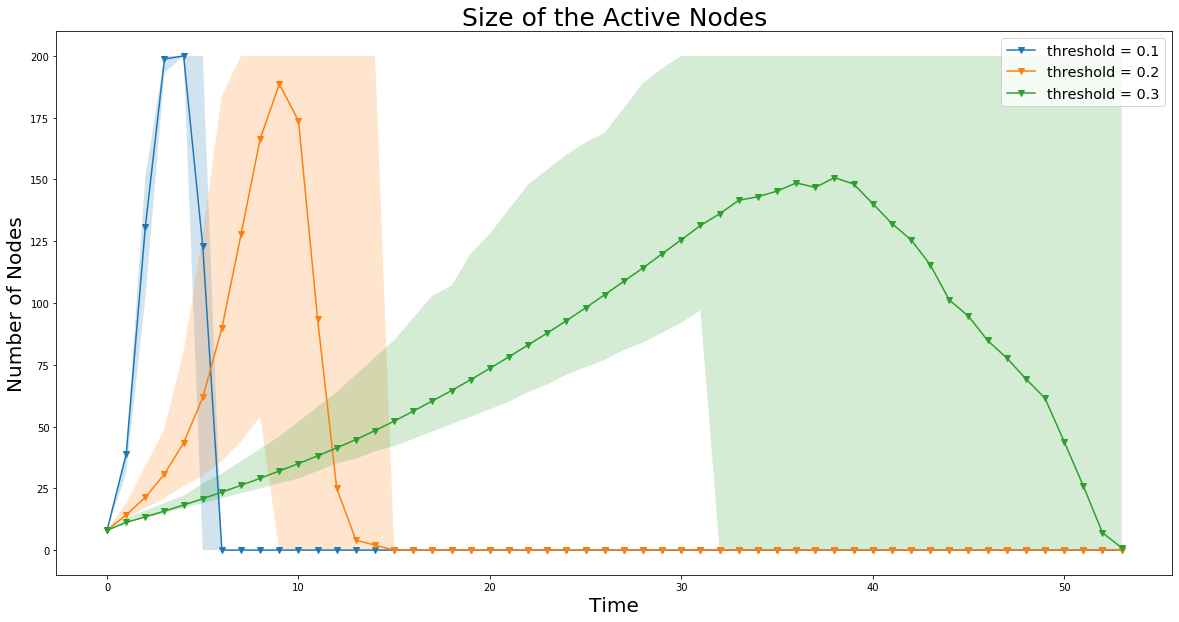

In [48]:
labels = ['threshold = 0.1', 'threshold = 0.2', 'threshold = 0.3']
Q = [Q1,Q2,Q3]
display_comm_sizes(Q,labels)
plt.savefig('/Users/bengieru/Dane/docs/source/contagion_sizes.png')

# 5) You can look at the persistence diagrams of the above distance matrices
### Then compute the lifetime difference between largest two 1d-voids

Deprecated parameter. It has been replaced by max_intervals


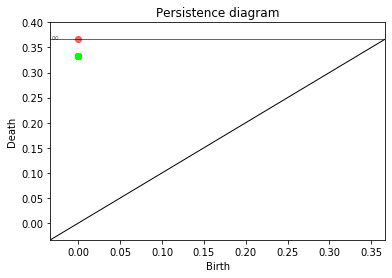

In [23]:
pers1 = ring_latt_k_regular.compute_persistence(D1, spy = True)
delta1 = ring_latt_k_regular.one_d_Delta(pers1)
#pers1, delta1

Deprecated parameter. It has been replaced by max_intervals


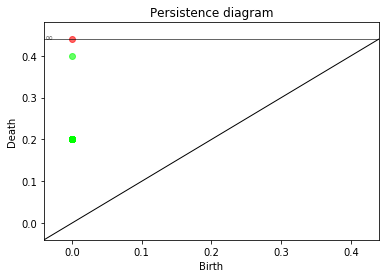

In [24]:
pers2 = ring_latt_k_regular.compute_persistence(D2, spy = True)
delta2 = ring_latt_k_regular.one_d_Delta(pers2)
#pers2, delta2

Deprecated parameter. It has been replaced by max_intervals


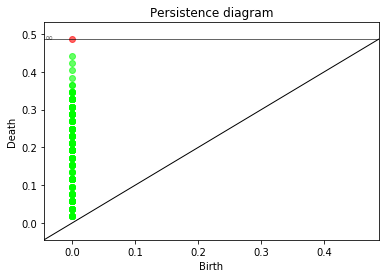

In [49]:
pers3 = ring_latt_k_regular.compute_persistence(D3, spy = True)
delta3 = ring_latt_k_regular.one_d_Delta(pers3)
#pers3, delta3
plt.savefig('/Users/bengieru/Dane/docs/source/pers_diag.png')

Deprecated parameter. It has been replaced by max_intervals


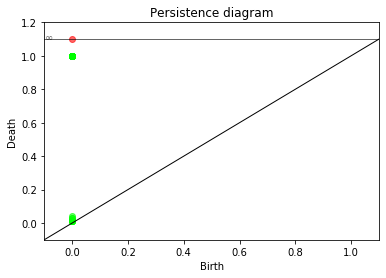

In [26]:
pers4 = ring_latt_k_regular.compute_persistence(D4, spy = True)
delta4 = ring_latt_k_regular.one_d_Delta(pers4)
#pers4, delta4

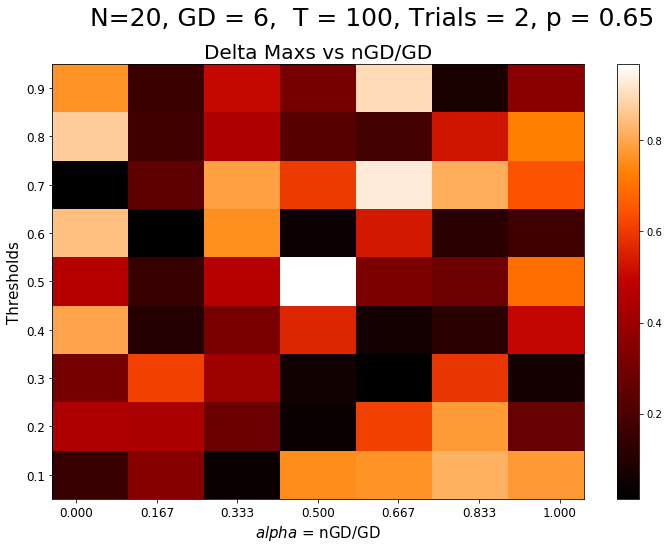

In [48]:
bands = 3
d2s = [1,2,3,4,5,6]
thresholds = np.linspace(0.1,0.9,9)
fig,ax = plt.subplots(1,1,figsize = (12,8))
im = ax.imshow(dm, cmap = 'gist_heat', extent = [-.05,1.05,0.05,0.95])
fig.suptitle('N=%d, GD = %d,  T = %d, Trials = %d, p = %.2f'%(n,2*bands,T, Trials, p),fontsize = 25)
ax.set_title('Delta Maxs vs nGD/GD', fontsize = 20)
ax.set_xticks(np.array([0]+d2s)/(2*bands))
ax.set_yticks(thresholds)
ax.set_xlabel('$alpha$ = nGD/GD', fontsize = 15 )
ax.set_ylabel('Thresholds', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
fig.colorbar(im)